### Importing Libs

In [5]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Building model

In [6]:
def parse_csv(row):
    ds = tf.strings.split(row, ",")
    label = tf.strings.to_number(ds[0])
    features = tf.strings.to_number(
        ds[2:6]
    )  # return pickup and drop off location only
    return features, label


def create_dataset(pattern, batch_size):
    ds = tf.data.TextLineDataset(pattern)
    ds = ds.map(parse_csv).batch(batch_size)
    return ds

In [7]:
model = Sequential(
    [
        Dense(
            units=32, input_shape=(4,), activation="relu", name="input_layer"
        ),
        Dense(units=8, activation="relu", name="hidden"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

In [8]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [9]:
trainds = create_dataset(pattern="../datasets/taxi-train.csv", batch_size=32)

evalds = create_dataset(pattern="../datasets/taxi-valid.csv", batch_size=32)

In [11]:
%%time

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    epochs=10,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8884 - rmse: 9.1403 - mse: 95.8884 - val_loss: 110.2174 - val_rmse: 9.7630 - val_mse: 110.2174
Epoch 2/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8843 - rmse: 9.1400 - mse: 95.8843 - val_loss: 110.2172 - val_rmse: 9.7630 - val_mse: 110.2172
Epoch 3/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8794 - rmse: 9.1397 - mse: 95.8794 - val_loss: 110.2170 - val_rmse: 9.7631 - val_mse: 110.2170
Epoch 4/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8742 - rmse: 9.1394 - mse: 95.8742 - val_loss: 110.2167 - val_rmse: 9.7630 - val_mse: 110.2167
Epoch 5/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8686 - rmse: 9.1390 - mse: 95.8686 - val_loss: 110.2163 - val_rmse: 9.7630 - val_mse: 110.2163
Epoch 6/10
230/230 [==============================] - 1s 3ms/step - loss: 95.8628 - rmse: 9.1386 - mse: 95.8628 - val_loss: 110.2160 - val_r

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 32)                160       
                                                                 
 hidden (Dense)              (None, 8)                 264       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


<Axes: >

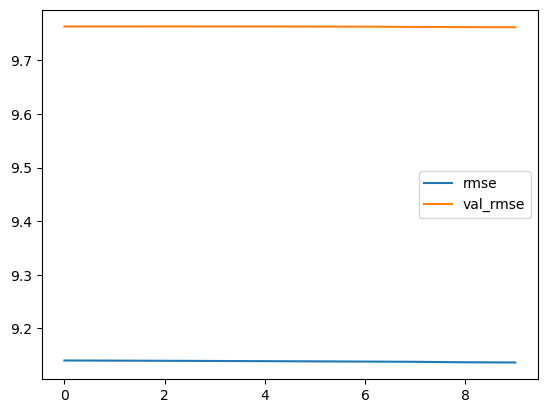

In [12]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

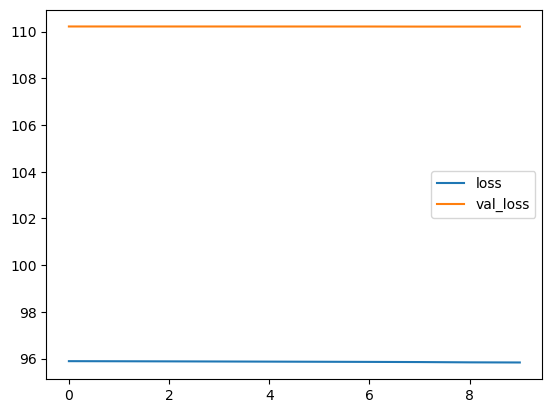

In [14]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

In [15]:
model.predict([[-73.982683, 40.742104, -73.983766, 40.755174]])

1/1 [==============================] - 0s 84ms/step


array([[11.7257185]], dtype=float32)

### Exporting Model

In [16]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)

INFO:tensorflow:Assets written to: ./export/savedmodel/20230518212047/assets


INFO:tensorflow:Assets written to: ./export/savedmodel/20230518212047/assets


In [17]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

2023-05-18 21:20:57.472459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: serving_default_input_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20230518212047
./export/savedmodel/20230518212047/variables
./export/savedmodel/20230518212047/variables/variables.data-00000-of-00001
./export/savedmodel/20230518212047/variables/variables.index
./export/savedmodel/20230518212047/assets
./export/savedmodel/20230518212047/saved_model.pb
./export/savedmodel/20230518212047/fingerprint.pb
